# Lab12

## 一. 引入需要的資料集

In [1]:
from glob import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from scipy.fftpack import dct

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          filename ='1.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=500)
    plt.show()

## 二. 讀取資料並抽取特徵

In [11]:
def feat_avg(path):
    audio, _ = librosa.load(path, sr=22050)
    mfcc = librosa.feature.mfcc(audio)
    feat = np.average(mfcc, axis=1)
    return feat

def feat_DCT(path):
    audio, _ = librosa.load(path, sr=22050)
    DCT = dct(audio)[:20]
    return DCT

In [4]:
#%% Loading training and test data
DataPath = './Datasets'
FeaPath  = './Features/MFCC'
train_path = sorted(glob(os.path.join(DataPath, 'wav_train', 'train*.wav')))
test_path = sorted(glob(os.path.join(DataPath, 'wav_dev', 'dev*.wav')))

In [5]:
warnings.filterwarnings('ignore')
train_data = [feat_avg(path) for path in train_path]
test_data = [feat_avg(path) for path in test_path]

In [6]:
#%% Reading labels
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]

In [7]:
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [12]:
warnings.filterwarnings('ignore')
train_data = [feat_DCT(path) for path in train_path]
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
X_train2 = np.vstack(train_data)
X_train_std2 = sc.transform(X_train2)

## 三. 執行PCA降維

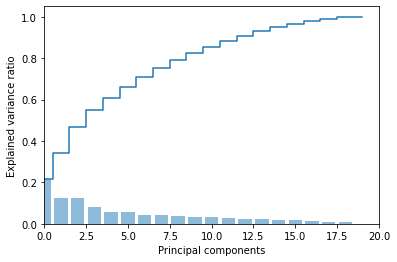

In [13]:
#用PCA進行降維
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

#用 principal components 和 explained variance ratio 作圖，以此決定 n_components 的值
plt.bar(range(0, len(X_train_pca[1])), pca.explained_variance_ratio_, alpha = 0.5, align = 'center')
plt.step(range(0,len(X_train_pca[1])), np.cumsum(pca.explained_variance_ratio_), where = 'mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim(0, 20)       #看完原本的圖後，將範圍鎖定在0~400，比較能看出components要取哪個值
plt.savefig('PCA_MFCC', dpi=500)
plt.show()

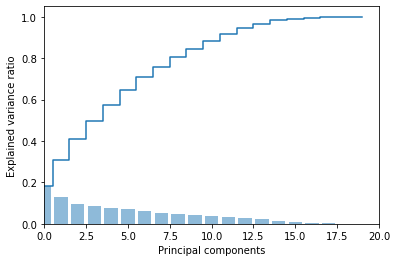

In [15]:
#用PCA進行降維
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std2)

#用 principal components 和 explained variance ratio 作圖，以此決定 n_components 的值
plt.bar(range(0, len(X_train_pca[1])), pca.explained_variance_ratio_, alpha = 0.5, align = 'center')
plt.step(range(0,len(X_train_pca[1])), np.cumsum(pca.explained_variance_ratio_), where = 'mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim(0, 20)       #看完原本的圖後，將範圍鎖定在0~400，比較能看出components要取哪個值
plt.savefig('PCA_DCT', dpi=500)
plt.show()

In [16]:
reduction_dimension = 13
reduction_dimension_DCT = 10

In [17]:
def feat_extraction_avg_13(path):
    audio, _ = librosa.load(path, sr=22050)
    mfcc = librosa.feature.mfcc(audio)[:reduction_dimension]
    feat = np.average(mfcc, axis=1)
    return feat

def feat_extraction_avg_std(path):
    audio, _ = librosa.load(path)
    mfcc = librosa.feature.mfcc(audio)[:reduction_dimension]
    feat1 = np.average(mfcc, axis=1)
    feat2 = np.std(mfcc, axis=1)
    feat = np.concatenate((feat1, feat2))
    return feat

def feat_PSC(path):
    audio, _ = librosa.load(path, sr=22050)
    psk = dct(np.abs(np.fft.rfft(audio)), norm = 'ortho')[:reduction_dimension_DCT]
    return psk

def feat_PCC(path):
    audio, _ = librosa.load(path, sr=22050)
    pcc = dct(np.log10(np.abs(np.fft.rfft(audio))))[:reduction_dimension_DCT]
    return pcc

def feat_DCT(path):
    audio, _ = librosa.load(path, sr=22050)
    DCT = dct(audio)[:reduction_dimension_DCT]
    return DCT

## 四. k-fold learning與Grid-search

### 1. 平均值

In [18]:
warnings.filterwarnings('ignore')
train_data = [feat_extraction_avg_13(path) for path in train_path] # 改這裡
test_data = [feat_extraction_avg_13(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [19]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_micro',
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.6408904881101376
{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [20]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_avg = clf.predict(X_test_std)
results_avg = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_avg})
results_avg.to_csv('results_avg13.csv', index=False)

In [21]:
y3 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y3, average='micro'))

Test accuracy: 0.710
F1_score: 0.710


Confusion matrix


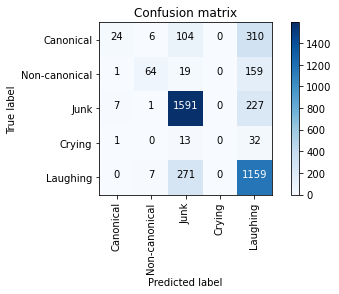

In [22]:
classNames = ['Canonical', 'Non-canonical', 'Junk', 'Crying', 'Laughing']
cm = confusion_matrix(y_true=y_train, y_pred=y3)
plot_confusion_matrix(cm, classNames, filename = 'avg_13.png')

### 2. 平均值+標準差

In [38]:
warnings.filterwarnings('ignore')
train_data = [feat_extraction_avg_std(path) for path in train_path] # 改這裡
test_data = [feat_extraction_avg_std(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [39]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_micro', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_avg_std = clf.predict(X_test_std)
results_avg_std = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_avg_std})
results_avg_std.to_csv('results_avg_std_f1.csv', index=False)

y4 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y4, average='micro'))

0.6591602002503129
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Test accuracy: 0.754
F1_score: 0.754


Confusion matrix


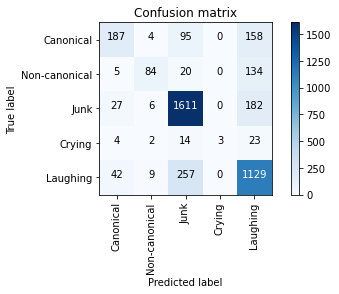

In [40]:
cm = confusion_matrix(y_true=y_train, y_pred=y4)
plot_confusion_matrix(cm, classNames, filename = 'avg_std_f1.png')

### 3. PSC

In [26]:
warnings.filterwarnings('ignore')
train_data = [feat_PSC(path) for path in train_path] # 改這裡
test_data = [feat_PSC(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [27]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_micro', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_PSC = clf.predict(X_test_std)
results_PSC = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_PSC})
results_PSC.to_csv('results_PSC.csv', index=False)

y5 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y5, average='micro'))

0.5745785356695869
{'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Test accuracy: 0.593
F1_score: 0.593


Confusion matrix


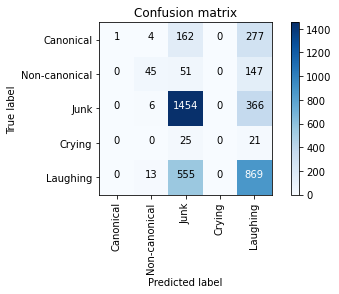

In [28]:
cm = confusion_matrix(y_true=y_train, y_pred=y5)
plot_confusion_matrix(cm, classNames, filename = 'PSC.png')

### 4. PCC

In [29]:
warnings.filterwarnings('ignore')
train_data = [feat_PCC(path) for path in train_path] # 改這裡
test_data = [feat_PCC(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [30]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_micro', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_PCC = clf.predict(X_test_std)
results_PCC = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_PCC})
results_PCC.to_csv('results_PCC.csv', index=False)

y6 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y6, average='micro'))

0.5658207133917397
{'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Test accuracy: 0.677
F1_score: 0.677


Confusion matrix


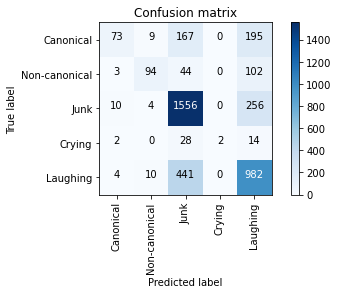

In [31]:
cm = confusion_matrix(y_true=y_train, y_pred=y6)
plot_confusion_matrix(cm, classNames, filename = 'PCC.png')

### 5. DCT

In [32]:
warnings.filterwarnings('ignore')
train_data = [feat_DCT(path) for path in train_path] # 改這裡
test_data = [feat_DCT(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [33]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='f1_micro', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_DCT = clf.predict(X_test_std)
results_DCT = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_DCT})
results_DCT.to_csv('results_DCT.csv', index=False)

y7 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y6, average='micro'))

0.48298185231539426
{'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
Test accuracy: 0.564
F1_score: 0.677


Confusion matrix


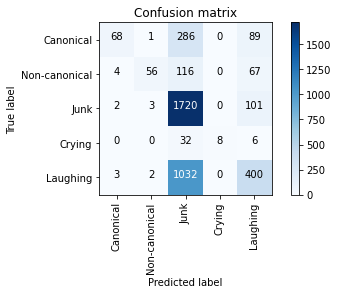

In [34]:
cm = confusion_matrix(y_true=y_train, y_pred=y7)
plot_confusion_matrix(cm, classNames, filename = 'PCC.png')

### 6. AVG+STD 換scoring

In [35]:
warnings.filterwarnings('ignore')
train_data = [feat_extraction_avg_std(path) for path in train_path] # 改這裡
test_data = [feat_extraction_avg_std(path) for path in test_path] # # 改這裡
labels = pd.read_csv(os.path.join(DataPath, 'labels_raw.csv'))
name2label = dict((row['file_name'], row['label']) for idx, row in labels.iterrows())
train_label = [name2label[os.path.basename(path)] for path in train_path]
test_label = [name2label[os.path.basename(path)] for path in test_path]
X_train = np.vstack(train_data)
y_train = np.array(train_label)
X_test = np.vstack(test_data)
y_test = np.array(test_label)
sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [36]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
y_predict_avg_std = clf.predict(X_test_std)
results_avg_std = pd.DataFrame({'file_name':[os.path.basename(f) for f in test_path], 'prediction':y_predict_avg_std})
results_avg_std.to_csv('results_avg_std.csv', index=False)

y4 = clf.predict(X_train_std)
print('Test accuracy: %.3f' % clf.score(X_train_std, y_train)) # 對測試集進行預測
print('F1_score: %.3f' % f1_score(y_true=y_train, y_pred=y4, average='micro'))

0.6591602002503129
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Test accuracy: 0.754
F1_score: 0.754


Confusion matrix


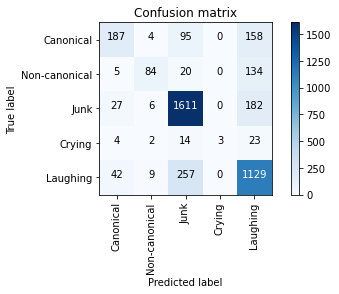

In [37]:
cm = confusion_matrix(y_true=y_train, y_pred=y4)
plot_confusion_matrix(cm, classNames, filename = 'avg_std.png')